
# WaveSense: A Spiking Neural Network with Temporal Convolutions

In this notebook we will demonstrate how to run and visualize a WaveSense network as described in https://arxiv.org/pdf/2111.01456.pdf.


The key feature of this model is its temporal convolution layer which is inspired by the famous WaveNet architecture from Google: 
https://arxiv.org/pdf/1609.03499.pdf and
https://deepmind.com/blog/article/wavenet-generative-model-raw-audio
 

<img src="images/wavesense.png" alt="Dilations" width="800"/>


WaveNet uses so called "dilated convolutional layers" as depicted in panel A. Dilated convolutional layers are basically the same as a normal convolutional layers, execpt that the kernel is causal and sparse in the time domain. By choosing the sparseness (dilations) in a smart way, no information is lost but much less parameters have to be trained.

We adapt this method in our spiking neural network implementation. As can be seen in panel A, a dilated connection means that there is a connection which is fast (instantaneous) and one which is delayed by the dilation value. In order to correctly implement that in a SNN, we could simply use an axonal delay for the dilated connection (panel B). Unfortunately, axonal delays are not supported by our hardware. Hence, we chose to represent the fast connection with a synapse having a short time constant and the dilated connection having a long time constant (panel C). Note that this means that our dilated neuron model differs from the standard LIF neuron model as it has two synaptic currents with different time constants.


There are additional parts to the model worth mentioning. The dilated connection happens in a computational block called "WaveBlock". Moreover, the WaveBlock uses a residual connection to connect to the next block and also a skip connection directly to the readout layer. 

The WaveBlock looks like this:

    A single WaveBlock
                          ▲
           To next block  │            ┌────────────┐
       ┌──────────────────┼────────────┤ WaveBlock  ├───┐
       │                  │            └────────────┘   │
       │ Residual path   .─.                            │
       │    ─ ─ ─ ─ ─ ─▶( + )                           │
       │    │            `─'                            │
       │                  ▲                             │
       │    │             │                             │
       │               .─────.                          │
       │    │         ( Spike )                         │
       │               `─────'                          │
       │    │             ▲                             │
       │                  │                             │
       │    │       ┌──────────┐                        │
       │            │  Linear  │                        │
       │    │       └──────────┘         Skip path      │    Skip
       │                  ▲       ┌──────┐    .─────.   │ connections
       │    │             ├──────▶│Linear│──▶( Spike )──┼──────────▶
       │                  │       └──────┘    `─────'   │
       │    │          .─────.                          │
       │              ( Spike )                         │
       │    │          `─────'                          │
       │                 ╲┃╱                            │
       │    │             ┃ Dilation                    │
       │            ┌──────────┐                        │
       │    │       │  Linear  │                        │
       │            └──────────┘                        │
       │    │             ▲                             │
       │     ─ ─ ─ ─ ─ ─ ─│                             │
       └──────────────────┼─────────────────────────────┘
                          │ From previous block
                          │




The WaveSense network stacks multiple such WaveBlocks and adds a two layered readout:




    The WaveSense network
                                                         Threshold
                                                         on output
                                                .───────.
                                               (Low-pass )────▶
                                                `───────'
                                                    ▲
                                                    │
                                              ┌──────────┐
                                              │  Linear  │
                                              └──────────┘
                                                    ▲
                                                    │
                                                 .─────.
                                                ( Spike )
    ┌──────────────────────┐         Skip        `─────'
    │                      ├┐      outputs          ▲
    │   WaveBlock stack    │├┬───┐                  │
    │                      ││├┬──┤      .─.   ┌──────────┐
    └┬─────────────────────┘││├──┴┬───▶( + )─▶│  Linear  │
     └┬─────────────────────┘││───┘     `─'   └──────────┘
      └┬─────────────────────┘│
       └──────────────────────┘
                   ▲
                   │
                .─────.
               ( Spike )
                `─────'
                   ▲
                   │
             ┌──────────┐
             │  Linear  │
             └──────────┘
                   ▲  Spiking
                   │   input

Now, that the model is introduced, let's get started and define the task.

In [1]:
import warnings
warnings.filterwarnings('ignore')
!pip install ffmpeg-python
!pip install git+https://gitlab.com/synsense/rockpool.git
!pip install tonic
!wget https://www.dropbox.com/s/j2u7nlsb1vei6pm/model_heysnips_16.json

import matplotlib
import matplotlib.pyplot as plt

  Cloning https://gitlab.com/synsense/rockpool.git to /tmp/pip-req-build-9w_6qz54
  Running command git clone -q https://gitlab.com/synsense/rockpool.git /tmp/pip-req-build-9w_6qz54
  Created wheel for rockpool: filename=rockpool-2.3.dev0-py3-none-any.whl size=386774 sha256=2dfbb5336325ab77e2931e06c1b9bd0998bc05b41c481056cb6d7418f61daf6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-xtm4kxed/wheels/88/12/6a/e1999c6eef826d670141773fd2a66326cc4d2be5bdc27913ec
Successfully built rockpool
     |████████████████████████████████| 79 kB 2.6 MB/s 
  Created wheel for importRosbag: filename=importRosbag-1.0.3-py3-none-any.whl size=25470 sha256=c0d223b4c880930898c0bac3787005468b0f35e22ffe00de5f34b9a637c686e1
  Stored in directory: /root/.cache/pip/wheels/9a/3e/7d/a37dd6112f5919fe54f9dde7f47ccb3616b61b0a30ac71394d
Successfully built importRosbag
--2022-03-17 09:55:51--  https://www.dropbox.com/s/j2u7nlsb1vei6pm/model_heysnips_16.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18

In [2]:
#@title
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import copy 
import librosa

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    bitsPerSecond: 16000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  recorder = new MediaRecorder(stream, options);
  //recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  audio = librosa.core.resample(audio.astype('float'), sr, 16000)
  audio = np.expand_dims(copy.deepcopy(audio), 0)

  return audio, 16000

## Imports

In [8]:
import torch
from tonic import audio_transforms
import tonic.transforms as transforms
from rockpool.nn.modules import LIFTorch, LIFBitshiftTorch
import librosa
from rockpool.parameters import Constant


Define parameters

In [5]:
#@title

# filter bank parameter
filterbank_params = {"sampling_freq": 16000,
                     "order": 2,
                     "low_freq": 100.,
                     "num_filters": 16,
                     "rectify": True}

# spike conv params
spike_conversion_params = {"shape": (filterbank_params['num_filters'], filterbank_params['num_filters']),
                           "tau_mem": 0.02,
                           "tau_syn": 0.002,
                           "bias": 0.0,
                           "has_rec": False,
                           "threshold": 0.4,
                           "dt": 1e-3,
                           "noise_std": 0.0}




In [9]:
# model params
model_params = {"dilations": [2, 4, 8, 16, 2, 4, 8, 16],
                "n_classes": 2,
                "n_channels_in": filterbank_params['num_filters'],
                "n_channels_res": 16,
                "n_channels_skip": 32,
                "n_hidden": 32,
                "kernel_size": 2,
                "bias": Constant(0.0),
                "smooth_output": False,
                "tau_mem": Constant(0.02),
                "base_tau_syn": Constant(0.02),
                "tau_lp": Constant(0.02),
                "threshold": Constant(1.0),
                "neuron_model": LIFBitshiftTorch,
                "dt": 0.01}

Now let's define the WaveSense network.

As the problem is simple, we use only `16` neurons per layer and `2` WaveBlocks. We want the time constants in the network as short as possible as long time constants blurr the data unnecessarily. On the other hand, we need long memory in the network so we use one long time constant in the second WaveBlock (`dilation = 16`). 

We can define the number of WaveBlocks and their time constants by the `dilations` parameter. Remember, the dilated connection in WaveBlock `i` has two time constants which are calculated as:
```
    tau_syn_0 = base_tau_syn
    tau_syn_1 = dilation[i] * base_tau_syn
```

Finally, WaveSense can low-pass the output of the readout with an exponential kernel (time constant `tau_lp`). This is not strictly necessary but can help to smooth the gradients.

We can also choose which implementation of the LIF neuron WaveSense should use. The options are:

    1) LIFTorch, the most standard LIF dynamics (default)
    2) LIFBitshiftTorch, simulates the bitshift decay as used on Xylo and hence can be successfully quantized after training
    3) LIFSlayer, speeds up the training drastically but won't be able to be quantized after training
    
Here, we use LIFTorch as the most standard implementation of the LIF dynamics.

In [6]:
#@title

# Functions for spike conversion
def _spike_conversion(sample):
        sample = torch.from_numpy(sample.T).to('cpu').unsqueeze(0)
        sample, _, _ = spike_conversion.evolve(sample)
        return sample[0].detach().numpy()
    
    
def _resample(sample):
    return librosa.resample(sample, orig_sr=filterbank_params['sampling_freq'], target_sr=1/spike_conversion_params['dt'])


spike_conversion = LIFTorch(**spike_conversion_params)

preprocess = transforms.Compose([audio_transforms.normalize,
                                 audio_transforms.MelButterFilterBank(**filterbank_params),
                                 _resample,
                                 _spike_conversion,
                                 audio_transforms.Bin(1/spike_conversion_params['dt'], 1/model_params['dt'], axis=0),
                                 ])

Load pre-trained model

In [10]:
from rockpool.nn.networks import WaveSenseNet

# Load model using LIFBitshiftTorch
model = WaveSenseNet(**model_params)
model.load("model_heysnips_16.json")
model.spk_out.threshold.data = torch.Tensor([10, 10])

## Record audio

In [11]:
audio, sr = get_audio()

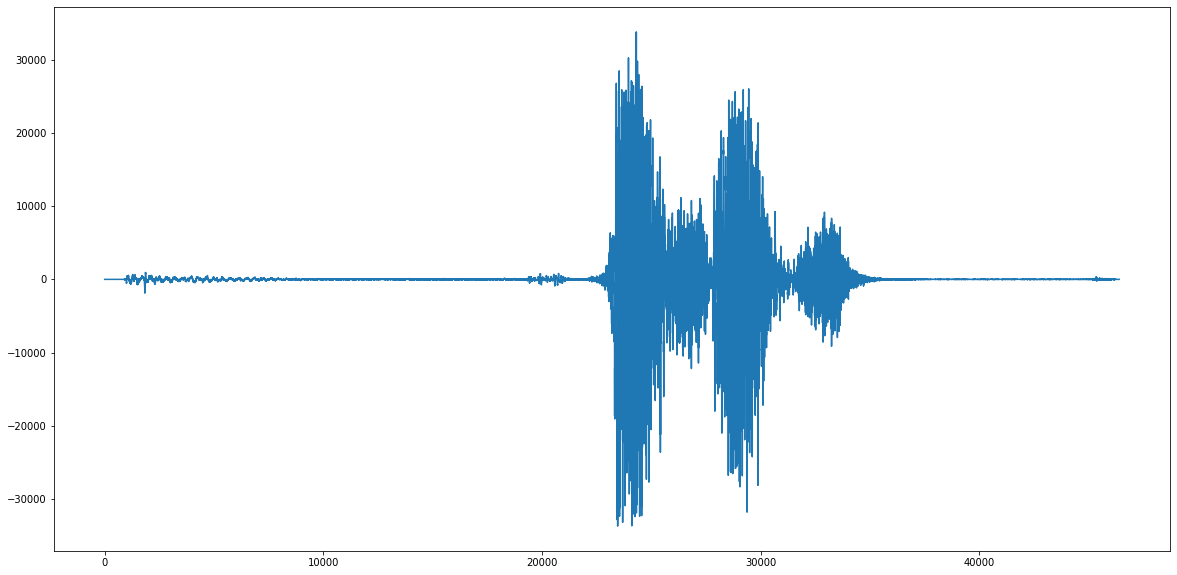

In [12]:
plt.figure(figsize=(20,10))
plt.plot(audio[0])
plt.show()

Run preprocessing and evolve model with this input

In [13]:
# preprocess data
inp = preprocess(audio)
model.reset_state()
# pass through model
out, state, rec = model(torch.Tensor(inp).unsqueeze(0), record =  True)



In [14]:
pred = torch.any(out[0, :, 1] > 0)

print(f"Keyword detected: {pred}")


Keyword detected: True


Visualize

Text(0.5, 0, 'Time [dt]')

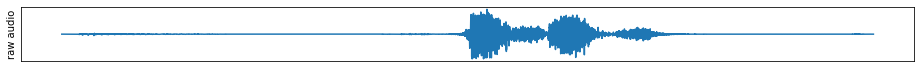

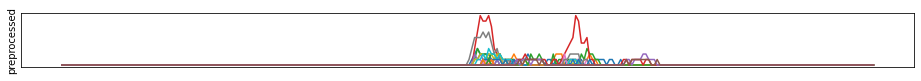

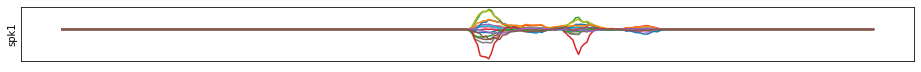

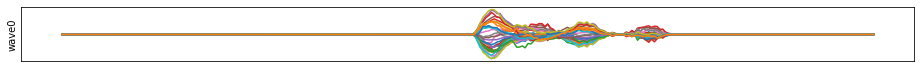

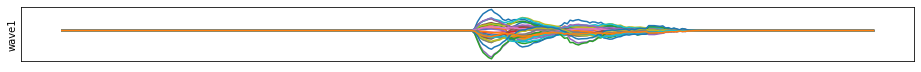

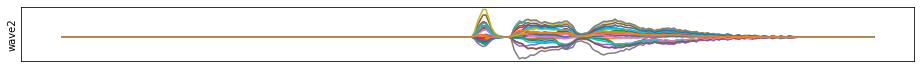

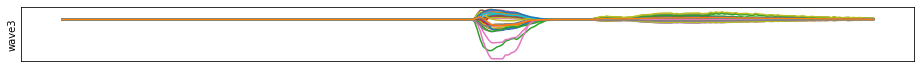

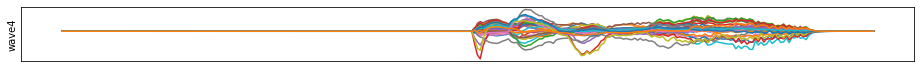

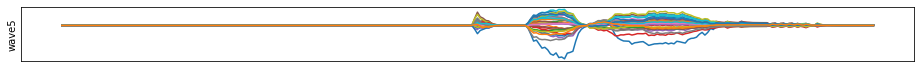

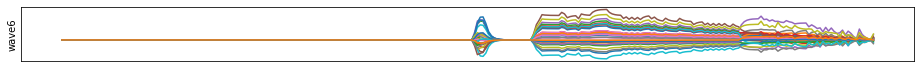

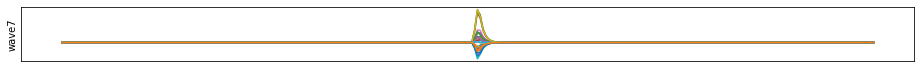

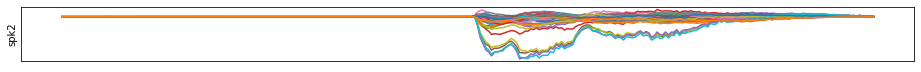

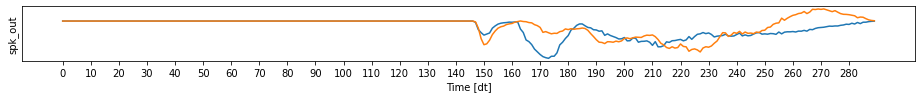

In [15]:
fig = plt.figure(figsize=(16, 1))
plt.plot(audio[0])
plt.yticks([])
plt.xticks([])
plt.ylabel("raw audio")

fig = plt.figure(figsize=(16, 1))
plt.plot(inp)
plt.yticks([])
plt.xticks([])
plt.ylabel("preprocessed")


for m in model.modules():

  if "wave" in m:
    fig = plt.figure(figsize=(16, 1))

    plt.plot(rec[m]['spk2_skip']['isyn'][0, :, :, 0].detach())
    plt.yticks([])
    plt.xticks([])
    plt.ylabel(m)
  elif "spk" in m:
    fig = plt.figure(figsize=(16, 1))

    plt.plot(rec[m]['isyn'][0, :, :, 0].detach())
    plt.yticks([])
    plt.xticks([])
    plt.ylabel(m)


plt.xticks(np.arange(0, out.shape[1], 10));
plt.xlabel("Time [dt]")

Visaualize spiking activity

Text(0.5, 0, 'Time [dt]')

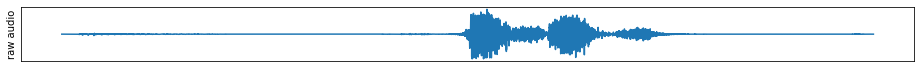

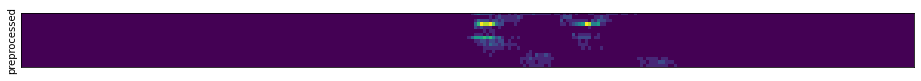

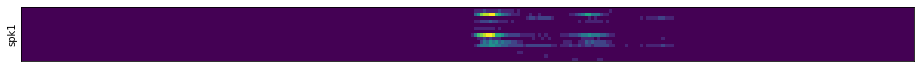

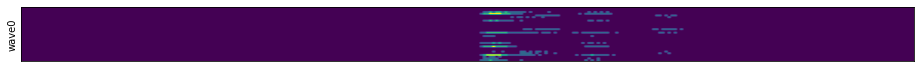

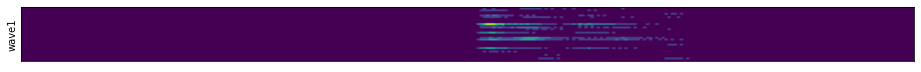

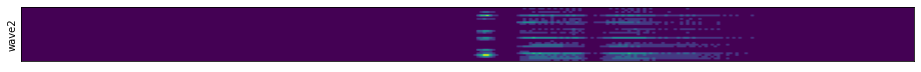

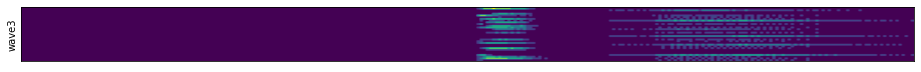

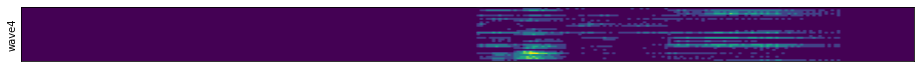

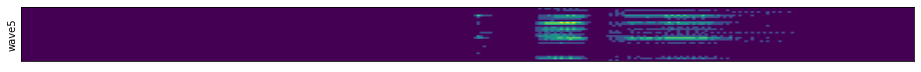

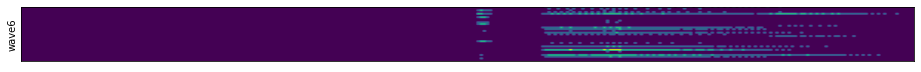

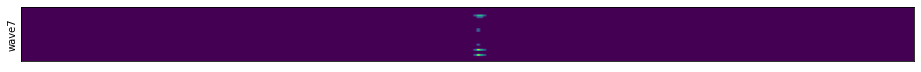

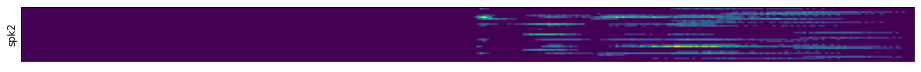

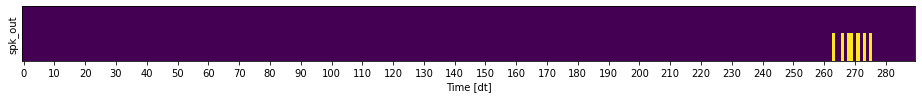

In [16]:
fig = plt.figure(figsize=(16, 1))
plt.plot(audio[0])
plt.yticks([])
plt.xticks([])
plt.ylabel("raw audio")

fig = plt.figure(figsize=(16, 1))
plt.imshow(inp.T, aspect='auto')
plt.yticks([])
plt.xticks([])
plt.ylabel("preprocessed")


for m in model.modules():

  if "wave" in m:
    fig = plt.figure(figsize=(16, 1))

    plt.imshow(rec[m]['spk2_skip']['spikes'][0, :, :].detach().T, aspect='auto')
    plt.yticks([])
    plt.xticks([])
    plt.ylabel(m)
  elif "spk" in m:
    fig = plt.figure(figsize=(16, 1))

    plt.imshow(rec[m]['spikes'][0, :, :].detach().T, aspect='auto')
    plt.yticks([])
    plt.xticks([])
    plt.ylabel(m)


plt.xticks(np.arange(0, out.shape[1], 10));
plt.xlabel("Time [dt]")

As can be seen, the output at the last timestep predicts the target correctly. Output neuron 0 is more active on the last timestep than output neuron 1 if `XOR(inp) == 0` and vice versa.

We can also visualize the activity of each layer in WaveSense by accessing the record dict returned by rockpool on each forward path. We can access the state of each layer (synaptic current and membrane potential) or the spiking output. 

Let's take a look at the spiking output.

What we can see here is that the first layers (including the first WaveBlock) respond quickly to the stimuli which is expected as the time constants of those layers are short. 

The second WaveBlock has the only long time constant in the network and is able to maintain an active state for the whole delay period. This reflects the memory in the network and can be utilized by the readout layer (the last layer).

We can save the model to json format using `model.save(path)` and load it again after initialization with `model.load(path)`.